In [1]:
import pandas as pd
import numpy as np
# import pickle5 as pickle
import pickle
import urllib.request
import scipy.spatial.distance

# img load and show
from PIL import Image
from ImageFunctions import show_image, load_image
import matplotlib.pyplot as plt

# models
from keras.models import load_model, Model
from keras.applications import vgg16

#load cnn model
from tensorflow import keras
import os


# color distributions
from ImageFunctions import get_color_description, histogram
import cv2
import imutils
import sklearn.preprocessing as preprocessing

Create vgg model

In [2]:
# create vgg model with correct input size
inputs = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=inputs)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

#dont want model weights to change durring training
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

In [149]:
def load_data(img_class):
    file_name = img_class.replace('/', '_')
    aws_path = 'https://streamlitwebapp2.s3.us-east-2.amazonaws.com/' + file_name +'_df.pkl'
    local_path = '/Users/racheldilley/Documents/lets-take-a-trip-data/AppData/' + file_name + '_df.pkl'
    requests = urllib.request.urlopen(aws_path)
    df = pickle.load(requests)
    # df = pickle.load(open(local_path, 'rb'))
    return df

def classify(img_vgg, model):
    '''
    find class using cnn model, using img vgg vector and return prediction
    '''
    cats = ['beaches/ocean', 'entertainment', 'gardens/zoo', 'landmarks', 'museums','parks']
    
    predictions = np.array(model.predict(img_vgg))
    print(predictions)
    pred = np.argmax(predictions) #find max value
    
    return cats[pred] 

def get_bottleneck_features(model, input_img):
    '''
    get vgg vector features of array of images
    '''
    input_imgs = np.array([input_img])
    
    features = model.predict(input_imgs, verbose=0)
    return features


def get_distance(img_feats, feats):
    '''
    get distance between vectors
    '''
    return scipy.spatial.distance.cosine(img_feats, feats)   


def get_recommendations(img_class,img_array, img_vgg):
    '''
    get df of top attractions and siplay 3 images from top attractions
    '''
    # df = load_data()
    # load df with color and vgg descriptions
    df = load_data(img_class)

    #get color distribution feature vector
    bins = [8,8,8]
    img_color_des = get_color_description(img_array, bins)

    # get distances between color vectors of all imgs in class and distances between vgg vectors
    df['color_feats'] = df.apply(lambda row: get_distance(img_color_des, row[3]), axis=1)
    df['vgg_feats'] = df.apply(lambda row: get_distance(img_vgg, row[4]), axis=1)

    # create color and vgg vectors and standardize 
    min_max_scaler = preprocessing.MinMaxScaler()
    color_array = df['color_feats'].values.astype(float).reshape(-1,1)
    scaled_color_array = min_max_scaler.fit_transform(color_array)
   
    vgg_array = df['vgg_feats'].values.astype(float).reshape(-1,1)
    scaled_vgg_array = min_max_scaler.fit_transform(vgg_array)
    

    # drop color and vgg columns
    df.drop(['color_feats','vgg_feats'], axis=1, inplace=True)

    # combine arrays, weighing vgg vector depending on class
    if img_class in ['beaches/ocean']:
        total_distance =  0.5*scaled_vgg_array + scaled_color_array
    elif img_class in ['gardens/zoo']:
        total_distance =  10*scaled_vgg_array + scaled_color_array
    elif img_class in ['entertainment', 'landmarks', 'museums']:
        total_distance =  20*scaled_vgg_array + scaled_color_array
    else:
        total_distance =  1* scaled_vgg_array + scaled_color_array
   
    # add new distance column
    df['distance'] = total_distance

    # groupb attractions and find mean distance
    grouped_df = df.groupby(['name', 'location'])['distance'].mean()
    grouped_df = pd.DataFrame(grouped_df).reset_index()

    # remove attractins with no locations
    grouped_df['length'] = grouped_df.location.str.len()
    grouped_df = grouped_df[grouped_df.length > 3]

    # sort by distance ascending
    grouped_df.sort_values(by=['distance'], ascending=True, inplace=True)

    # get top 3 attractions
    top_df = grouped_df[:3].reset_index()
    atts = [top_df.loc[0,'name'], top_df.loc[1,'name'], top_df.loc[2,'name']]

    # groupp by attraction, and get groups for top 3 attractions
    grouped = df.groupby('name')
    groups = []
    for attraction in atts:
        groups.append(grouped.get_group(attraction))
    show_recommendations(groups, atts) #show recommendations

    return top_df
    

def show_recommendations(groups, atts):
    '''
    show 3 images for each recommended attraction
    '''
    for idx, group in enumerate(groups):
        df = pd.DataFrame(group).reset_index()
        imgs = [df.loc[1,'url'], df.loc[25,'url'], df.loc[19,'url']]
        
        fig = plt.figure()
        fig.suptitle(atts[idx], fontsize="x-large")
        for i in range(3):
            a=fig.add_subplot(1,3,i+1)
            image = load_image(imgs[i])
            plt.imshow(image,cmap='Greys_r')
            plt.axis('off')

load model

In [144]:
model = load_model('../Models/vgg_cnn2')
# model = load_model('../Models/vgg_cnn_final.h5')
# model = load_model('../final_vgg_cnn.h5')

load test image

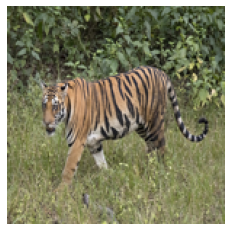

In [147]:
image = Image.open("../test_imgs/C.jpg") 
# image_sequence = an_image.getdata()
img = image.resize((150, 150)) 
image_array = np.array(img)

#show uploaded img
show_image(image_array)

[[0.10355222 0.05803317 0.709969   0.20928806 0.12807411 0.3937298 ]]
gardens/zoo
   index                        name  \
0    100               St. Louis Zoo   
1     46  Jacksonville Zoo & Gardens   
2     18    Cleveland Metroparks Zoo   

                                      location  distance  length  
0  1 Government Dr, Saint Louis, MO 63110-1332  8.800917      43  
1    370 Zoo Pkwy, Jacksonville, FL 32218-5770  9.540947      41  
2  3900 Wildlife Way, Cleveland, OH 44109-3132  9.772479      43  


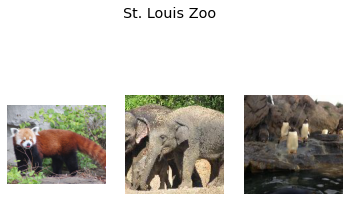

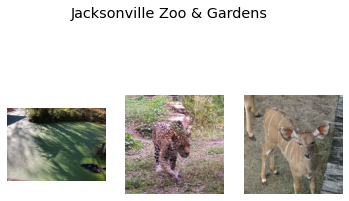

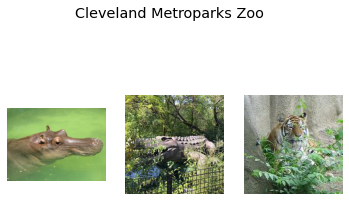

In [150]:
img_std = image_array/255
img_vgg = get_bottleneck_features(vgg_model, img_std)

#classify with cnn model
label = classify(img_vgg, model)
print(label)

#get recommedations 
df = get_recommendations(label, image_array, img_vgg)
print(df)